<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Image_Segmentation_with_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download Repo for masked R-CNN**

In [1]:
!git clone https://github.com/alsombra/Mask_RCNN-TF2

Cloning into 'Mask_RCNN-TF2'...
remote: Enumerating objects: 1004, done.
remote: Total 1004 (delta 0), reused 0 (delta 0), pack-reused 1004
Receiving objects: 100% (1004/1004), 137.72 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (588/588), done.


In [2]:
%cd Mask_RCNN-TF2

!pwd  # check current working dir

/content/Mask_RCNN-TF2
/content/Mask_RCNN-TF2


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 13.0 MB/s eta 0:00:00


In [4]:
!python setup.py install

/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  warnings.warn(
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'


In [5]:
%cd ..

/content


In [6]:
pwd

'/content'

**Import Needed Modules**

In [7]:
import os
import sys
import cv2
import numpy as np
import skimage.io  # to work with image in RGB although can use cv2 and convert to RGB
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
ROOT_DIR = os.path.abspath("./Mask_RCNN-TF2")

sys.path

['/content',
 '/env/python',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/root/.ipython']

In [9]:
# adds the Mask_RCNN to the sys path i.e the name of py files to import
sys.path.append(ROOT_DIR)

sys.path

['/content',
 '/env/python',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/Mask_RCNN-TF2']

In [10]:
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib   # the mask_rnn model

In [11]:
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))

sys.path

['/content',
 '/env/python',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/Mask_RCNN-TF2',
 '/',
 '/content/Mask_RCNN-TF2/samples/coco/']

In [12]:
import coco


MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

MODEL_DIR, IMAGE_DIR

('/content/Mask_RCNN-TF2/logs', '/content/Mask_RCNN-TF2/images')

**To handle Compatibility Problems**

In [13]:
# to avoid issues when running this with tf2
# allows running tf1 code in inteactive shell with having to use Session context
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

**Loading Pre-trained neural network**

In [14]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [15]:
class InferenceConfig(coco.CocoConfig):
  GPU_COUNT = 1   # specifies number of GPU to use
  IMAGES_PER_GPU = 1   # specifies batch_size, default is 2

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [16]:
MODEL_DIR  # dir to store our model

'/content/Mask_RCNN-TF2/logs'

In [17]:
# inference mode, means mode for prediction. i.e no training
network = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = config)
network.load_weights(COCO_MODEL_PATH, by_name = True)

Instructions for updating:
Use fn_output_signature instead


**Detecting Objects**

In [18]:
# 80 classes the coco dataset, along with 1 extra class for the background class
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

print(len(class_names))              
class_names[1], class_names.index("person")

81


('person', 1)

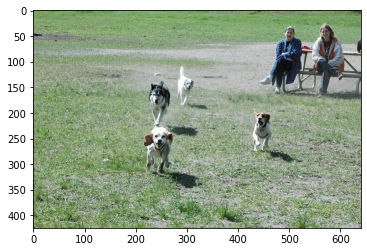

In [19]:
# test image to use for segmentation problem
# image2 = cv2.imread('/content/Mask_RCNN-TF2/images/2516944023_d00345997d_z.jpg')      #BGR
image = skimage.io.imread("/content/Mask_RCNN-TF2/images/2516944023_d00345997d_z.jpg")  #RGB
plt.imshow(image);

In [20]:
# number of images being passed must be same as batch_size in config
results = network.detect([image], verbose = 0)

results

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[{'rois': array([[195, 426, 277, 467],
         [226, 216, 321, 273],
         [106, 280, 189, 314],
         [ 32, 445, 159, 527],
         [136, 225, 231, 268],
         [ 27, 541, 168, 607],
         [ 75, 476, 164, 634]], dtype=int32),
  'class_ids': array([17, 17, 17,  1, 17,  1, 14], dtype=int32),
  'scores': array([0.9997004 , 0.9996582 , 0.99960464, 0.9991359 , 0.9979887 ,
         0.9974267 , 0.91667485], dtype=float32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
       

In [22]:
# classes found are 
print(f"{class_names[17]}, {class_names[1]} and {class_names[14]}")

dog, person and bench


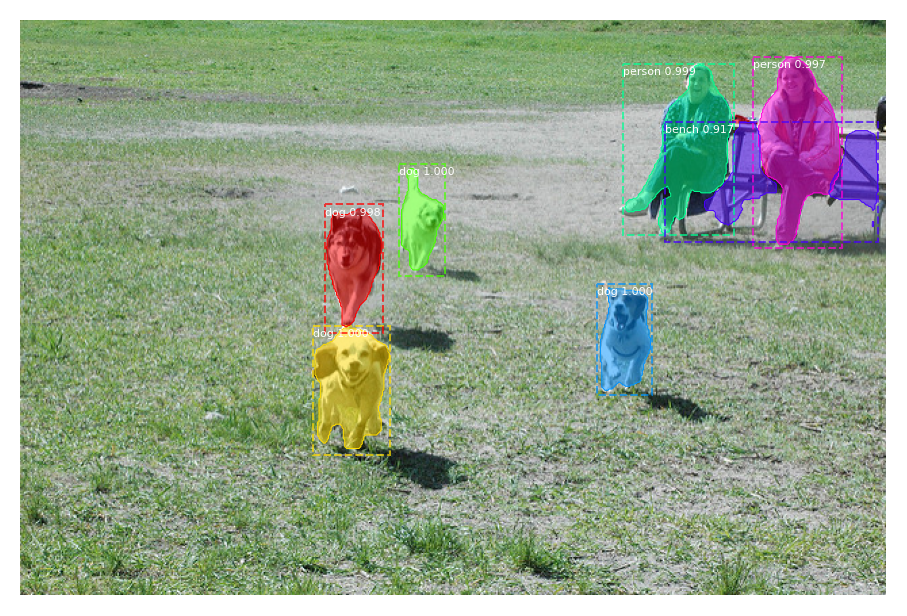

In [23]:
r = results[0]

# class_ids of coco must match to index of class_names in our class_names_list for accurate results
visualize.display_instances(image, r["rois"], r["masks"], 
                            r["class_ids"], class_names, r["scores"])

**Removing the Backgound**

In [24]:
np.unique(r["masks"], return_counts = True)  # gets unique values of masks and counts of the values

(array([False,  True]), array([1881594,   22406]))

In [29]:
# 7 items where detected, where each array of masks has true for where that item in focus is and false where other areas 
# and even other detected and segmented images not in focus
r["masks"].shape

(425, 640, 7)

In [63]:
# takes image, result and index of detected class in detected class_ids we want to work on
def segment(image, r, index):
  mask = r["masks"][:,:, index]  # mask of detected obj in focus

  mask = np.stack((mask, ) * 3, axis = -1)  # adds color channel to mask

  mask = mask.astype("uint8")  # converts true to 1 and false to 0

  bg = 255 - mask * 255 # using BODMAS, so product before subtraction
  #print(mask, mask.min(), mask.max())

  mask_show = np.invert(bg) # bitwise_inversion to get image along with false mask in all black and true mask in all white
  # plt.imshow(mask_show)

  mask_img = image * mask  # here false mask is in black and true mask is image
  # plt.imshow(mask_img)
  
  result = mask_img + bg  # here false mask is white and true mask is image
  # plt.imshow(mask_show)

  return result, mask_show


In [64]:
segmentation, mask_obj = segment(image, r, 0)

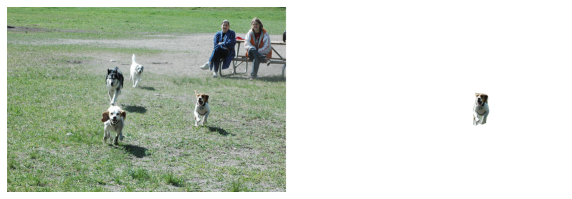

In [65]:
def show_segment(image, r, index, show_mask = False):
  segmentation, mask_obj = segment(image, r, index)
  plt.subplots(1, figsize=(10,10))
  plt.axis('off')
  if show_mask == True:
    plt.imshow(np.concatenate([mask_obj, segmentation], axis = 1))
  else:
    plt.imshow(np.concatenate([image, segmentation], axis = 1))

show_segment(image, r, 0, False)

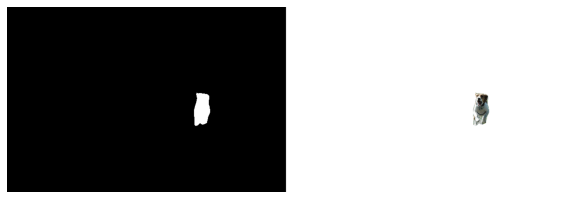

In [66]:
show_segment(image, r, 0, True)

In [67]:
r["rois"], len(r["rois"]), len(r["class_ids"])

(array([[195, 426, 277, 467],
        [226, 216, 321, 273],
        [106, 280, 189, 314],
        [ 32, 445, 159, 527],
        [136, 225, 231, 268],
        [ 27, 541, 168, 607],
        [ 75, 476, 164, 634]], dtype=int32), 7, 7)

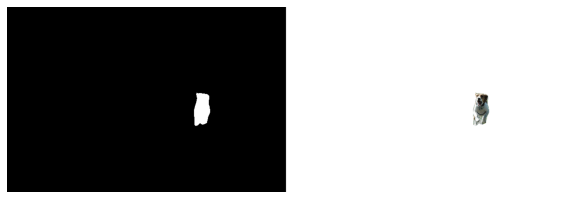

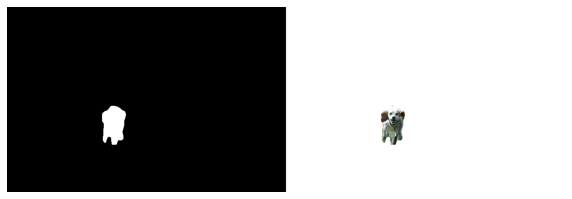

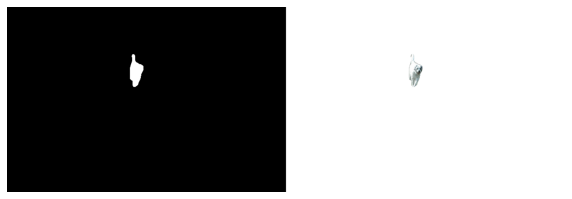

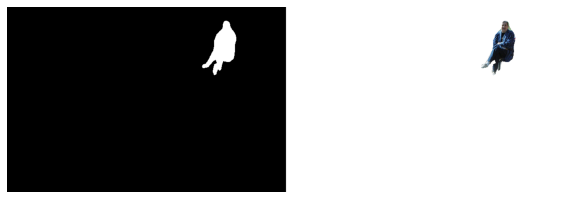

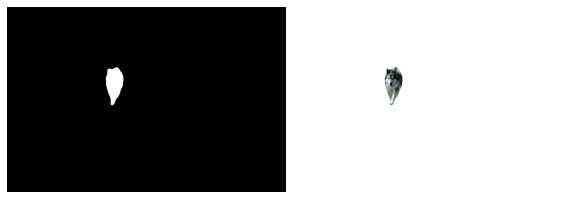

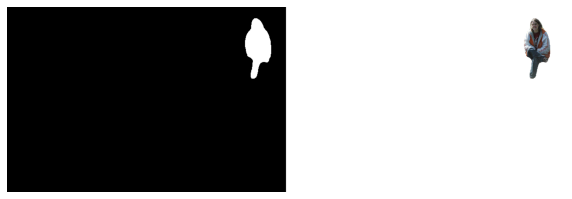

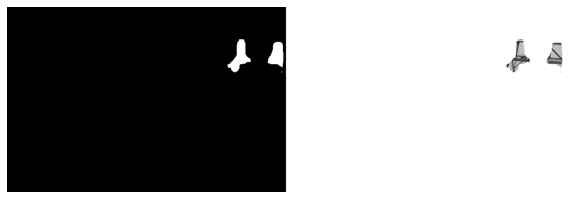

In [68]:
for i in range(len(r["class_ids"])):
  show_segment(image, r, i, True)

**Segmentation in Videos**